# Imports & load data

In [18]:
from rdkit import Chem
import numpy as np
import os
import sys
import tarfile
from collections import Counter

import matplotlib.pyplot as plt
params = {'text.usetex': True, 
          'text.latex.unicode': True,
          'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 6
plt.rcParams["text.latex.preamble"] = [
    r'\usepackage{siunitx}',
    r'\sisetup{detect-all}',
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
    r'\usepackage{helvet}',
    r'\usepackage{sansmath}',
    r'\sansmath'
]

In [44]:
rxnsmiles = {'train': None, 'valid': None, 'test': None}

for key in rxnsmiles.keys():
    tar = tarfile.open("../rexgen_direct/data/{}.txt.proc.tar.gz".format(key), "r:gz")
    for member in tar.getmembers():
        f = tar.extractfile(member)
        if f is not None:
            lines = str(f.read()).split('\\n')
            rxnsmiles[key] = [line.split()[0] for line in lines][:-1]

In [45]:
for key in rxnsmiles:
    print('{}: {} examples'.format(key, len(rxnsmiles[key])))

train: 409035 examples
valid: 30000 examples
test: 40000 examples


## Make some histograms

In [108]:
num_rcts = {}
for key in rxnsmiles:
    num_rcts_lst = [rxnsmi.split('>')[0].count('.')+1 for rxnsmi in rxnsmiles[key]]
    num_rcts[key] = Counter(num_rcts_lst)
num_rcts['train']

Counter({2: 64127,
         3: 70809,
         4: 72374,
         5: 64848,
         6: 55690,
         7: 36802,
         8: 20723,
         9: 10553,
         10: 5448,
         11: 3676,
         12: 1926,
         13: 969,
         14: 462,
         15: 236,
         16: 127,
         17: 62,
         18: 31,
         19: 19,
         20: 6,
         21: 93,
         22: 40,
         23: 8,
         24: 3,
         25: 1,
         26: 1,
         29: 1})

In [109]:
num_prods = {}
for key in rxnsmiles:
    num_prods_lst = [rxnsmi.split('>')[-1].count('.')+1 for rxnsmi in rxnsmiles[key]]
    num_prods[key] = Counter(num_prods_lst)
num_prods['train']

Counter({1: 395497, 2: 13176, 3: 342, 4: 17, 5: 3})

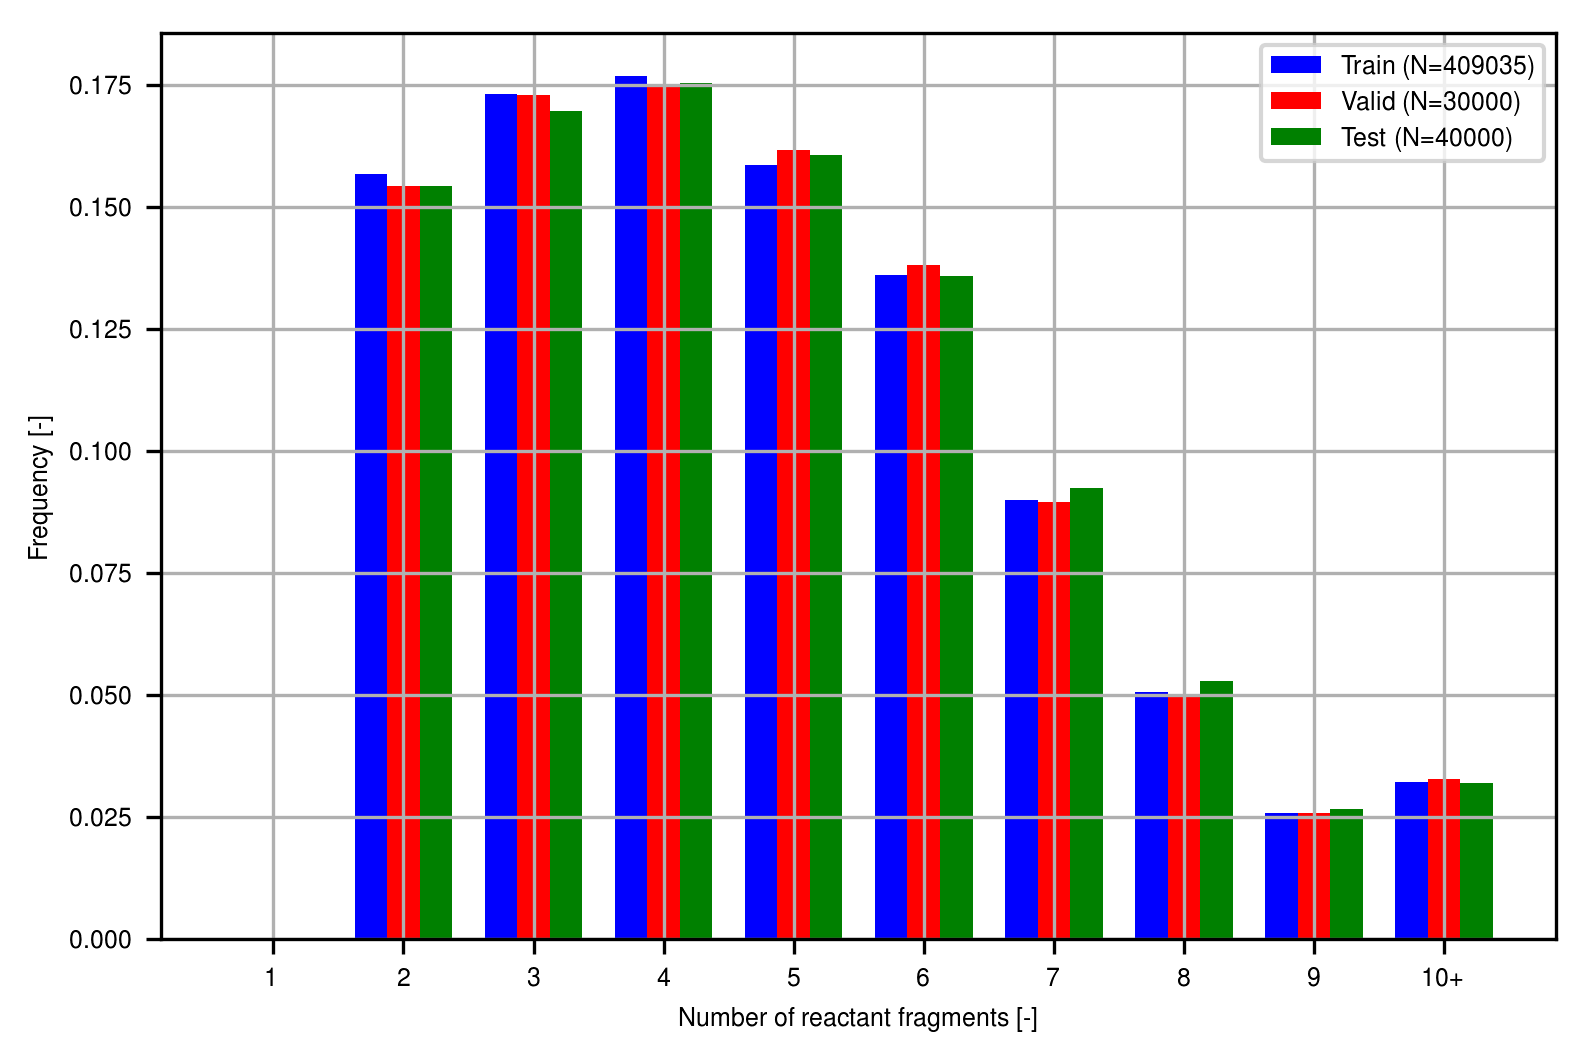

In [105]:
n = 11

fig = plt.figure(figsize=(6,4), dpi = 300)
colors = ['b', 'r', 'g']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    counter = num_rcts[key]
    counts_sum = sum(counter.values())
    xs = np.arange(1, n)
    xs[-1] = 1e9
    counts = np.zeros(np.shape(xs))
    for (k, v) in sorted(counter.items(), key=lambda x: x[0], reverse=True):
        for i in range(len(counts)):
            if xs[i] >= k:
                counts[i] = counts[i] + v
                break
    plt.bar(np.arange(len(counts)) + (offset-1)*.25, 
            counts / counts_sum, width=0.25,
            color=colors[offset])
    
plt.xlabel('Number of reactant fragments [-]')
xticklabels = [str(k) for k in xs if k != 1e9]
xticklabels.append('{}+'.format(xs[-2]+1))
plt.xticks(range(len(counts)), xticklabels)
plt.ylabel('Frequency [-]')
plt.grid(True)
plt.legend(['Train (N={})'.format(len(rxnsmiles['train'])), 
            'Valid (N={})'.format(len(rxnsmiles['valid'])), 
            'Test (N={})'.format(len(rxnsmiles['test']))])
plt.savefig('analysis/num_reactant_frags.png', bbox_inches = 'tight')
plt.show()

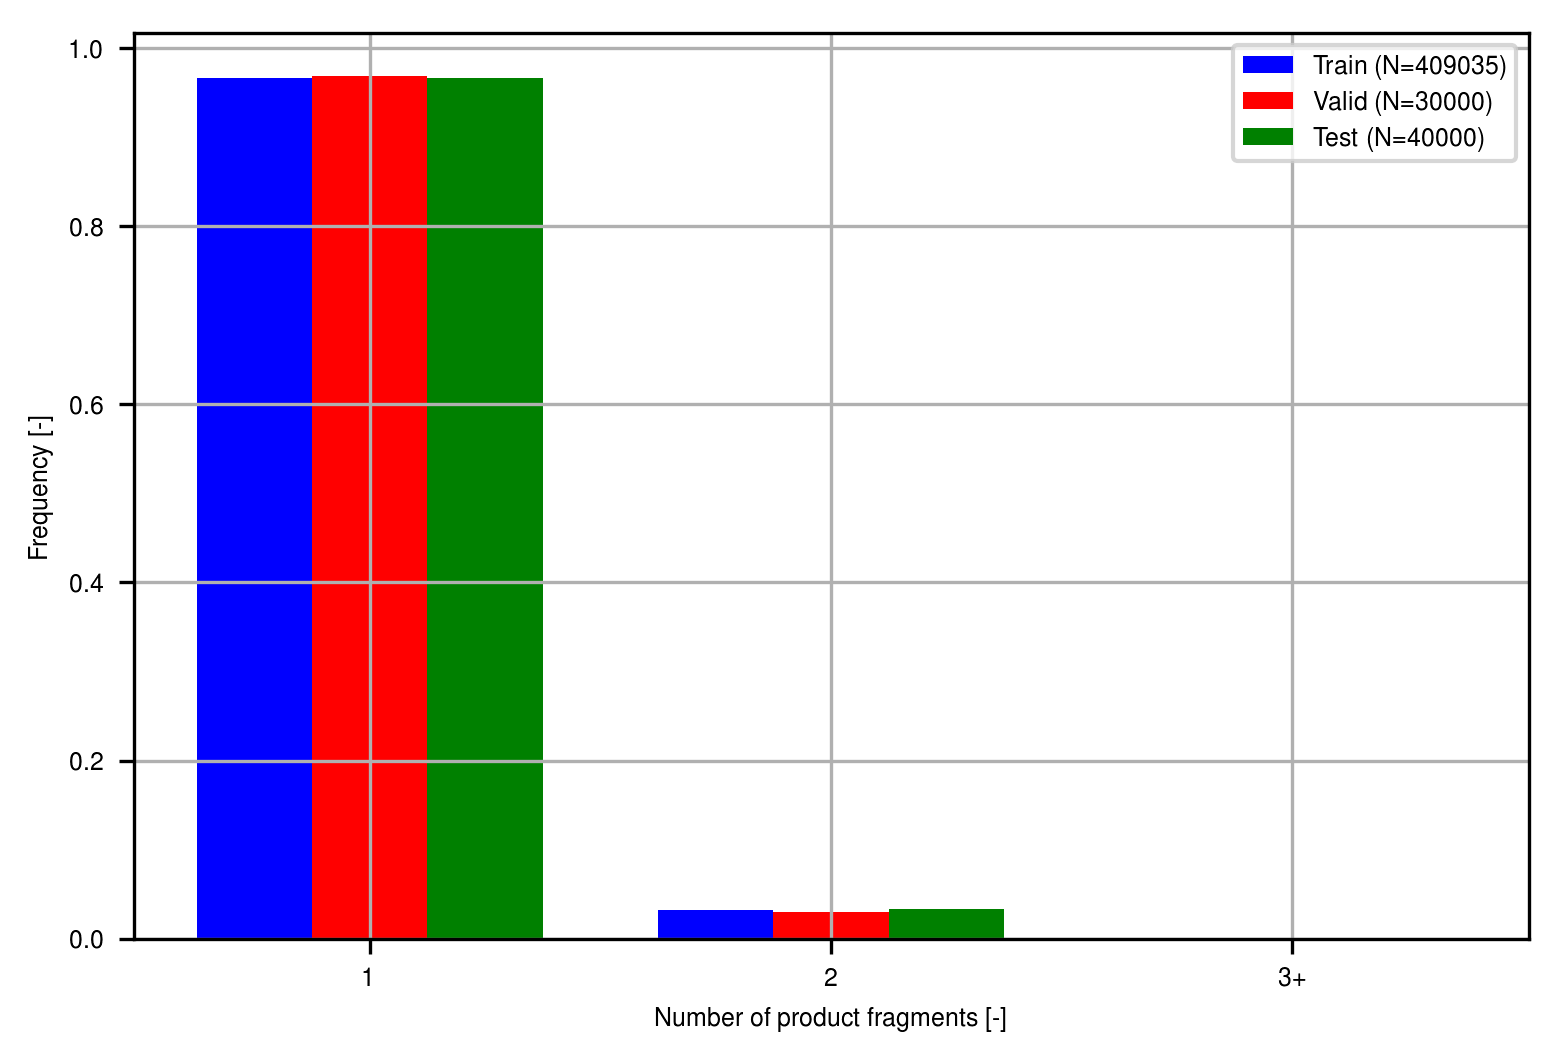

In [107]:
n = 4

# Visualize num reactants/etc. in histogram

fig = plt.figure(figsize=(6,4), dpi = 300)
colors = ['b', 'r', 'g']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    counter = num_prods[key]
    counts_sum = sum(counter.values())
    xs = np.arange(1, n)
    xs[-1] = 1e9
    counts = np.zeros(np.shape(xs))
    for (k, v) in sorted(counter.items(), key=lambda x: x[0], reverse=True):
        for i in range(len(counts)):
            if xs[i] >= k:
                counts[i] = counts[i] + v
                break
    plt.bar(np.arange(len(counts)) + (offset-1)*.25, 
            counts / counts_sum, width=0.25,
            color=colors[offset])
    
plt.xlabel('Number of product fragments [-]')
xticklabels = [str(k) for k in xs if k != 1e9]
xticklabels.append('{}+'.format(xs[-2]+1))
plt.xticks(range(len(counts)), xticklabels)
plt.ylabel('Frequency [-]')
plt.grid(True)
plt.legend(['Train (N={})'.format(len(rxnsmiles['train'])), 
            'Valid (N={})'.format(len(rxnsmiles['valid'])), 
            'Test (N={})'.format(len(rxnsmiles['test']))])
plt.savefig('analysis/num_product_frags.png', bbox_inches = 'tight')
plt.show()

### Atomic identities (in reactants)

In [140]:
from collections import defaultdict
import re 

atom_id_rcts = {}
for key in rxnsmiles:
    occurrences = defaultdict(int)
    for rxnsmi in rxnsmiles[key]:
        rcts = rxnsmi.split('>')[0]
        
        groups = re.findall(r'\[([^H:\-\+]+)[^\]]+\]', rcts, re.DOTALL)
        for atom_smi in groups:
            occurrences[atom_smi.lower()] += 1        
    atom_id_rcts[key] = occurrences
    
atom_id_prods = {}
for key in rxnsmiles:
    occurrences = defaultdict(int)
    for rxnsmi in rxnsmiles[key]:
        rcts = rxnsmi.split('>')[-1]
        
        groups = re.findall(r'\[([^H:\-\+]+)[^\]]+\]', rcts, re.DOTALL)
        for atom_smi in groups:
            occurrences[atom_smi.lower()] += 1        
    atom_id_prods[key] = occurrences

In [145]:
all_atom_types = set()
for key in rxnsmiles:
    all_atom_types |= set(atom_id_rcts[key].keys())
all_atom_types = sorted(all_atom_types, key=lambda x: atom_id_rcts['train'][x], reverse=True)
print(all_atom_types)

['c', 'o', 'n', 'cl', 'f', 's', 'na', 'br', 'k', 'p', 'i', 'b', 'li', 'si', 'pd', 'cs', 'al', 'cu', 'mg', 'sn', 'zn', 'fe', 'cr', 'mn', 'ti', 'pt', 'ca', 'ag', 'se', 'ni', 'ru', 'rh', 'os', 'co', 'ce', 'pb', 'ba', 'zr', 'yb', 'as', 'w', 'bi', 'ge', 'in', 'sb', 'sc', 'tl', 'mo', 'sm', 'ir', 're', 'au', 'ga', 'cd', 'xe', 'ta', 'nd', 'v', 'rb', 'la', 'dy', 'y', 'te', 'sr', 'ar', 'pr', 'be', 'eu']


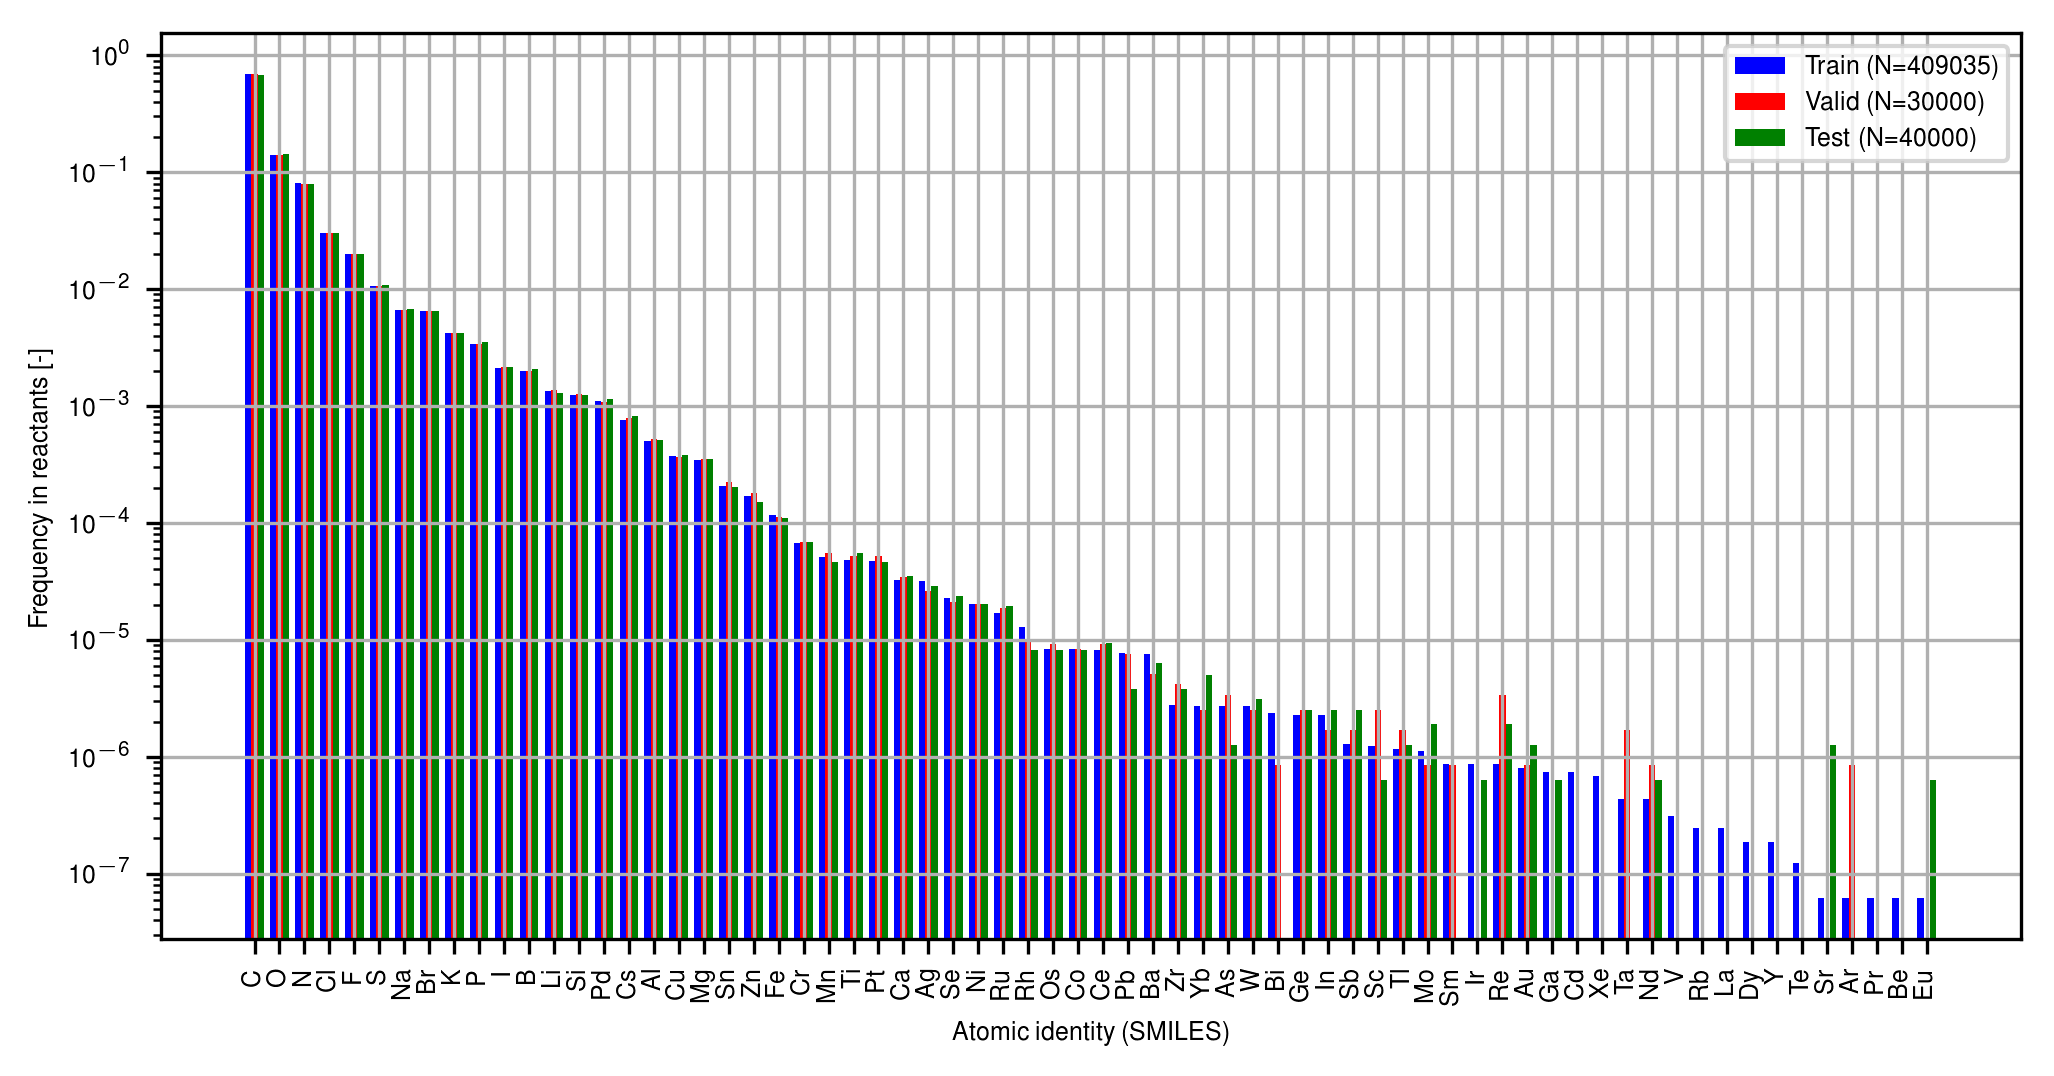

In [146]:
fig = plt.figure(figsize=(8,4), dpi = 300)
colors = ['b', 'r', 'g']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    vals = []
    for atom_type in all_atom_types:
        vals.append(atom_id_rcts[key][atom_type])
    vals = np.array(vals)
        
    plt.bar(np.arange(len(vals)) + (offset-1)*.25, 
            vals / np.sum(vals), width=0.25,
            color=colors[offset])
    
plt.xlabel('Atomic identity (SMILES)')
plt.xticks(range(len(vals)), 
           ['{}{}'.format(a[0].upper(), a[1:]) for a in all_atom_types],
          rotation='vertical')
plt.ylabel('Frequency in reactants [-]')
plt.grid(True)
plt.legend(['Train (N={})'.format(len(rxnsmiles['train'])), 
            'Valid (N={})'.format(len(rxnsmiles['valid'])), 
            'Test (N={})'.format(len(rxnsmiles['test']))])
plt.yscale('log')
plt.savefig('analysis/atom_type_freqs.png', bbox_inches = 'tight')
plt.show()

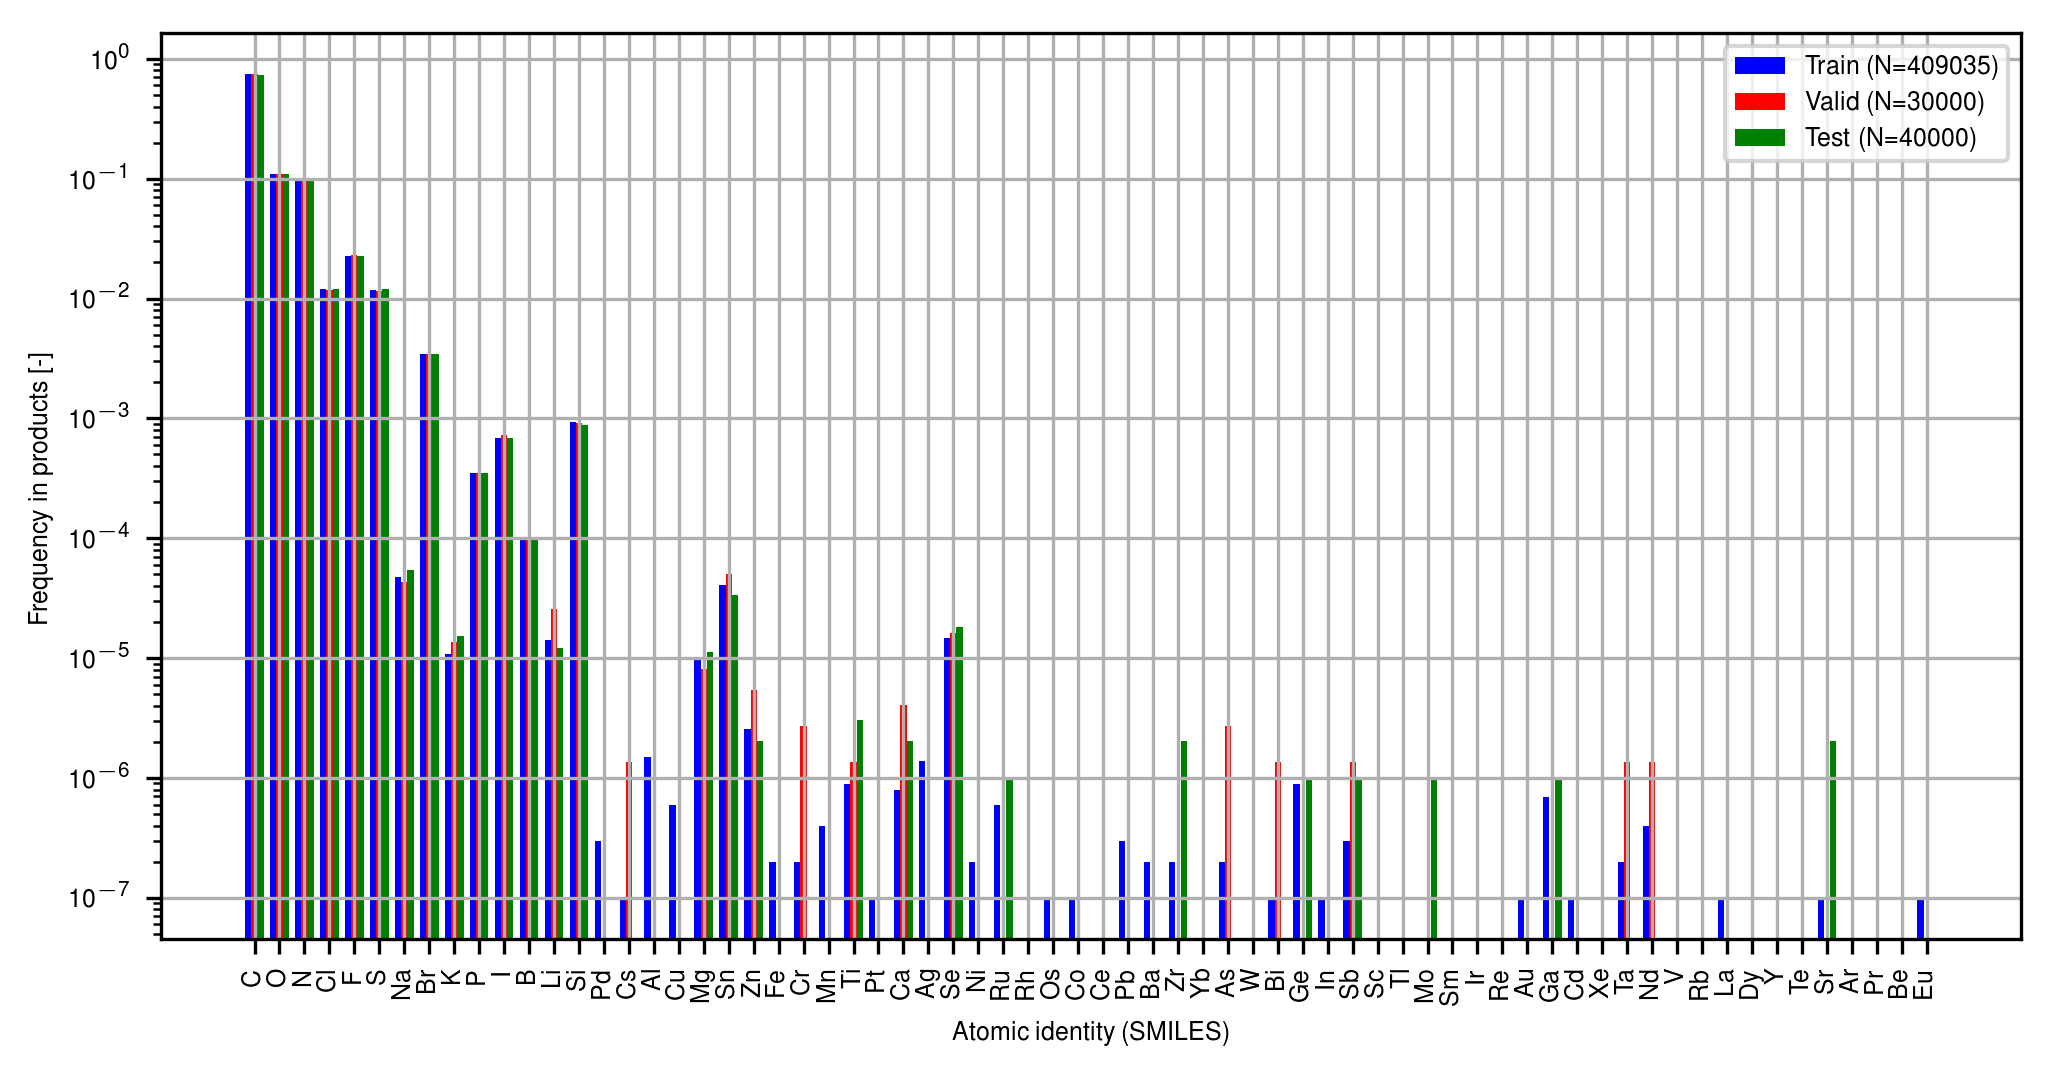

In [148]:
fig = plt.figure(figsize=(8,4), dpi = 300)
colors = ['b', 'r', 'g']

for offset, key in enumerate(['train', 'valid', 'test']):
    
    vals = []
    for atom_type in all_atom_types:
        vals.append(atom_id_prods[key][atom_type])
    vals = np.array(vals)
        
    plt.bar(np.arange(len(vals)) + (offset-1)*.25, 
            vals / np.sum(vals), width=0.25,
            color=colors[offset])
    
plt.xlabel('Atomic identity (SMILES)')
plt.xticks(range(len(vals)), 
           ['{}{}'.format(a[0].upper(), a[1:]) for a in all_atom_types],
          rotation='vertical')
plt.ylabel('Frequency in products [-]')
plt.grid(True)
plt.legend(['Train (N={})'.format(len(rxnsmiles['train'])), 
            'Valid (N={})'.format(len(rxnsmiles['valid'])), 
            'Test (N={})'.format(len(rxnsmiles['test']))])
plt.yscale('log')
plt.savefig('analysis/atom_type_freqs_prods.png', bbox_inches = 'tight')
plt.show()

### Template popularity analysis

In [149]:
import json
with open('../template_comparison/templates_readable.json', 'r') as fid:
    templates = json.load(fid)

In [164]:
counts = np.array([count for smarts, count in templates.items()])
from scipy.stats import rankdata
ranks = rankdata(-counts, 'ordinal')

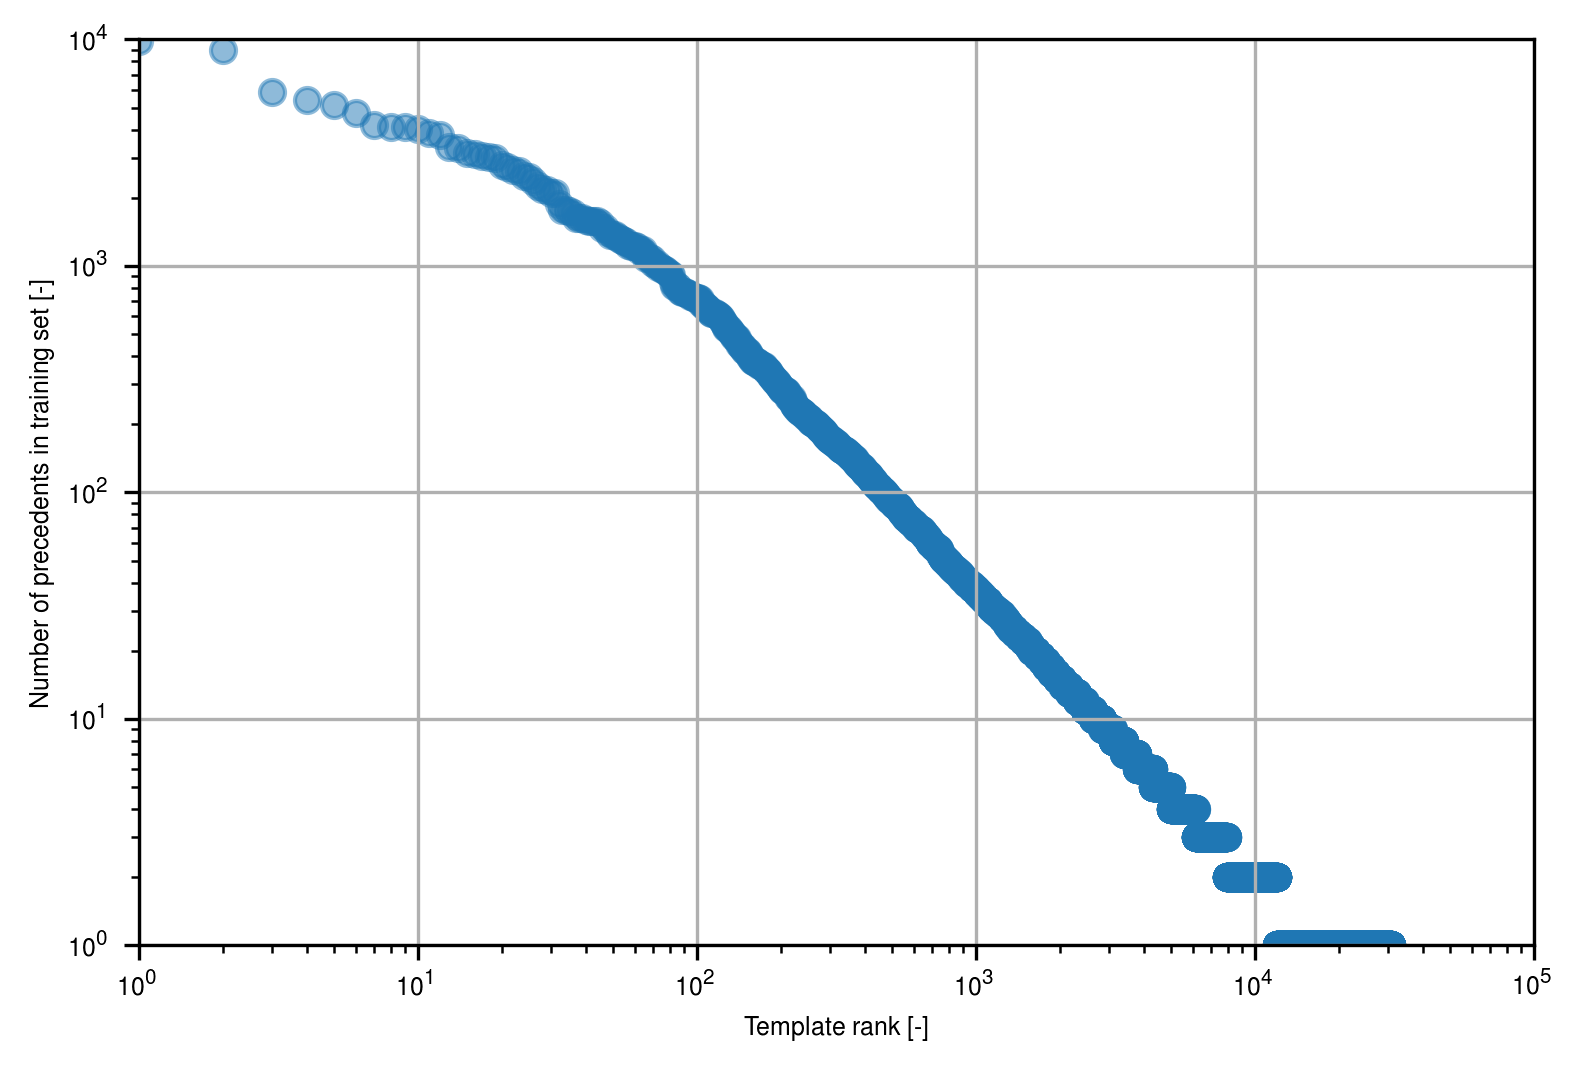

In [166]:
# Count
fig = plt.figure(figsize=(6,4), dpi = 300)
ax = plt.gca()
ax.scatter(ranks, counts, alpha = 0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.axis([1, np.power(10, np.ceil(np.log10(max(ranks)))), \
         np.power(10, np.floor(np.log10(min(counts)))), \
         np.power(10, np.ceil(np.log10(max(counts))))])
plt.xlabel('Template rank [-]')
plt.ylabel('Number of precedents in training set [-]')
plt.grid(True)
plt.savefig('analysis/template_popularities.png')
plt.show()


In [168]:
print('Number of templates: {}'.format(len(counts)))
print('Templates with count 1: {}'.format(np.sum(counts == 1)))
print('Templates with count < 5: {}'.format(np.sum(counts < 5)))

Number of templates: 30762
Templates with count 1: 18725
Templates with count < 5: 25756
